Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import igraph
import itertools
import binascii

In [2]:
VALENCE_DICT = {'C': 4, 'N': 3, 'Np': 4, 'O': 2, 'On': 1, 'F': 1, 'H': 1}
CHARGE_DICT = collections.defaultdict(int)
CHARGE_DICT['Np'] = 1
CHARGE_DICT['On'] = -1
HEAVY_ELEMENTS = ['C', 'N', 'Np', 'O', 'On', 'F']
ELEMENTS = HEAVY_ELEMENTS + ['H']
ELEMENT_COLORS = ['black', 'blue', 'light blue', 'red', 'pink', 'green', 'white']

BOND_SINGLE = 1
BOND_DOUBLE = 2
BOND_TRIPLE = 3

In [3]:
ELEMENTS[0]

'C'

In [9]:
class Stoichiometry(collections.namedtuple('Stoichiometry', ELEMENTS)):
    def num_atoms(self):
        return sum(self)
    
    def as_element_list(self):
        out = []
        for elem_idx, elem in enumerate(ELEMENTS):
            out += [elem] * self[elem_idx]
        return out
    
    def as_element_idx_list(self):
        out = []
        for elem_idx, _ in enumerate(ELEMENTS):
            out += [elem_idx] * self[elem_idx]
        return out
    def max_hydrogens(self):
      total_valence = 0
      total_atoms = 0
      for elem, count in self._asdict().items():
        total_atoms += count
        total_valence += count * VALENCE_DICT[elem]
      return total_valence - 2 * (total_atoms - 1)

def make_stoichiometry(**kwargs):
  """Makes a stoichiometry given keyword args for the elements.
  
  Example: make_stoichiometry(C=4, O=1)
  
  Return:
    Stoichiometry
  """
  stoich = Stoichiometry._make([0] * len(ELEMENTS))
  return stoich._replace(**kwargs)


In [10]:
def charge(stoich):
  return sum(count * CHARGE_DICT[elem] for elem, count in stoich._asdict().iteritems())

In [11]:
def enumerate_stoichiometries(num_heavy):
  def recursive_enumerate_stoichiometries(stoich, num_heavy, elements):
    if num_heavy == 0:
      # We are out of heavy atoms. If we are neutral, we are done!
      if charge(stoich) == 0:
        # parity of the number of hydrogens is determined, so use step size 2.
        for num_h in range(stoich.max_hydrogens(), -1, -2):
          yield stoich._replace(H=num_h)
    elif len(elements) == 1:
      for x in recursive_enumerate_stoichiometries(stoich._replace(**{elements[0]: num_heavy}), 0, elements[1:]):
        yield x
    else: 
      for this_count in range(num_heavy+1):
        for x in recursive_enumerate_stoichiometries(stoich._replace(**{elements[0]: this_count}), num_heavy - this_count, elements[1:]):
          yield x
  
  for x in recursive_enumerate_stoichiometries(make_stoichiometry(), num_heavy, HEAVY_ELEMENTS):
    yield x

In [12]:
for s in enumerate_stoichiometries(3):
    print s.as_element_list()

['O', 'F', 'F']
['O', 'O', 'F', 'H']
['O', 'O', 'O', 'H', 'H']
['O', 'O', 'O']
['Np', 'On', 'F', 'H', 'H']
['Np', 'On', 'F']
['Np', 'O', 'On', 'H', 'H', 'H']
['Np', 'O', 'On', 'H']
['N', 'F', 'F', 'H']
['N', 'O', 'F', 'H', 'H']
['N', 'O', 'F']
['N', 'O', 'O', 'H', 'H', 'H']
['N', 'O', 'O', 'H']
['N', 'Np', 'On', 'H', 'H', 'H', 'H']
['N', 'Np', 'On', 'H', 'H']
['N', 'Np', 'On']
['N', 'N', 'F', 'H', 'H', 'H']
['N', 'N', 'F', 'H']
['N', 'N', 'O', 'H', 'H', 'H', 'H']
['N', 'N', 'O', 'H', 'H']
['N', 'N', 'O']
['N', 'N', 'N', 'H', 'H', 'H', 'H', 'H']
['N', 'N', 'N', 'H', 'H', 'H']
['N', 'N', 'N', 'H']
['C', 'F', 'F', 'H', 'H']
['C', 'F', 'F']
['C', 'O', 'F', 'H', 'H', 'H']
['C', 'O', 'F', 'H']
['C', 'O', 'O', 'H', 'H', 'H', 'H']
['C', 'O', 'O', 'H', 'H']
['C', 'O', 'O']
['C', 'Np', 'On', 'H', 'H', 'H', 'H', 'H']
['C', 'Np', 'On', 'H', 'H', 'H']
['C', 'Np', 'On', 'H']
['C', 'N', 'F', 'H', 'H', 'H', 'H']
['C', 'N', 'F', 'H', 'H']
['C', 'N', 'F']
['C', 'N', 'O', 'H', 'H', 'H', 'H', 'H']
['C', '

In [13]:
for s in enumerate_stoichiometries(3):
    print s.as_element_idx_list()

[3, 5, 5]
[3, 3, 5, 6]
[3, 3, 3, 6, 6]
[3, 3, 3]
[2, 4, 5, 6, 6]
[2, 4, 5]
[2, 3, 4, 6, 6, 6]
[2, 3, 4, 6]
[1, 5, 5, 6]
[1, 3, 5, 6, 6]
[1, 3, 5]
[1, 3, 3, 6, 6, 6]
[1, 3, 3, 6]
[1, 2, 4, 6, 6, 6, 6]
[1, 2, 4, 6, 6]
[1, 2, 4]
[1, 1, 5, 6, 6, 6]
[1, 1, 5, 6]
[1, 1, 3, 6, 6, 6, 6]
[1, 1, 3, 6, 6]
[1, 1, 3]
[1, 1, 1, 6, 6, 6, 6, 6]
[1, 1, 1, 6, 6, 6]
[1, 1, 1, 6]
[0, 5, 5, 6, 6]
[0, 5, 5]
[0, 3, 5, 6, 6, 6]
[0, 3, 5, 6]
[0, 3, 3, 6, 6, 6, 6]
[0, 3, 3, 6, 6]
[0, 3, 3]
[0, 2, 4, 6, 6, 6, 6, 6]
[0, 2, 4, 6, 6, 6]
[0, 2, 4, 6]
[0, 1, 5, 6, 6, 6, 6]
[0, 1, 5, 6, 6]
[0, 1, 5]
[0, 1, 3, 6, 6, 6, 6, 6]
[0, 1, 3, 6, 6, 6]
[0, 1, 3, 6]
[0, 1, 1, 6, 6, 6, 6, 6, 6]
[0, 1, 1, 6, 6, 6, 6]
[0, 1, 1, 6, 6]
[0, 1, 1]
[0, 0, 5, 6, 6, 6, 6, 6]
[0, 0, 5, 6, 6, 6]
[0, 0, 5, 6]
[0, 0, 3, 6, 6, 6, 6, 6, 6]
[0, 0, 3, 6, 6, 6, 6]
[0, 0, 3, 6, 6]
[0, 0, 3]
[0, 0, 1, 6, 6, 6, 6, 6, 6, 6]
[0, 0, 1, 6, 6, 6, 6, 6]
[0, 0, 1, 6, 6, 6]
[0, 0, 1, 6]
[0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6]
[0, 0, 0, 6, 6, 6, 6, 6, 6]
[0, 0, 0, 

In [14]:
for s in enumerate_stoichiometries(4):
    print ''.join(s.as_element_list())

OOFF
OOOFH
OOOOHH
OOOO
NpOnFFH
NpOOnFHH
NpOOnF
NpOOOnHHH
NpOOOnH
NpNpOnOnHHHH
NpNpOnOnHH
NpNpOnOn
NFFF
NOFFH
NOOFHH
NOOF
NOOOHHH
NOOOH
NNpOnFHHH
NNpOnFH
NNpOOnHHHH
NNpOOnHH
NNpOOn
NNFFHH
NNFF
NNOFHHH
NNOFH
NNOOHHHH
NNOOHH
NNOO
NNNpOnHHHHH
NNNpOnHHH
NNNpOnH
NNNFHHHH
NNNFHH
NNNF
NNNOHHHHH
NNNOHHH
NNNOH
NNNNHHHHHH
NNNNHHHH
NNNNHH
NNNN
CFFFH
COFFHH
COFF
COOFHHH
COOFH
COOOHHHH
COOOHH
COOO
CNpOnFHHHH
CNpOnFHH
CNpOnF
CNpOOnHHHHH
CNpOOnHHH
CNpOOnH
CNFFHHH
CNFFH
CNOFHHHH
CNOFHH
CNOF
CNOOHHHHH
CNOOHHH
CNOOH
CNNpOnHHHHHH
CNNpOnHHHH
CNNpOnHH
CNNpOn
CNNFHHHHH
CNNFHHH
CNNFH
CNNOHHHHHH
CNNOHHHH
CNNOHH
CNNO
CNNNHHHHHHH
CNNNHHHHH
CNNNHHH
CNNNH
CCFFHHHH
CCFFHH
CCFF
CCOFHHHHH
CCOFHHH
CCOFH
CCOOHHHHHH
CCOOHHHH
CCOOHH
CCOO
CCNpOnHHHHHHH
CCNpOnHHHHH
CCNpOnHHH
CCNpOnH
CCNFHHHHHH
CCNFHHHH
CCNFHH
CCNF
CCNOHHHHHHH
CCNOHHHHH
CCNOHHH
CCNOH
CCNNHHHHHHHH
CCNNHHHHHH
CCNNHHHH
CCNNHH
CCNN
CCCFHHHHHHH
CCCFHHHHH
CCCFHHH
CCCFH
CCCOHHHHHHHH
CCCOHHHHHH
CCCOHHHH
CCCOHH
CCCO
CCCNHHHHHHHHH
CCCNHHHHHHH
CCCNHHHHH
CCCNHHH
CCCNH


In [9]:
list(enumerate_stoichiometries(3))[10].num_atoms()

3

In [16]:
make_stoichiometry(F=4).max_hydrogens()

-2

In [10]:
# NOT USING THIS
POSSIBLE_BONDS_FOR_VALENCE = []
# valence 0
POSSIBLE_BONDS_FOR_VALENCE.append([])
# valence 1
POSSIBLE_BONDS_FOR_VALENCE.append(
    POSSIBLE_BONDS_FOR_VALENCE[0] +
    [BOND_SINGLE])
# valence 2
POSSIBLE_BONDS_FOR_VALENCE.append(
    POSSIBLE_BONDS_FOR_VALENCE[1] +
    [[BOND_SINGLE, BOND_SINGLE], [BOND_DOUBLE]])
# valence 3
POSSIBLE_BONDS_FOR_VALENCE.append(
    POSSIBLE_BONDS_FOR_VALENCE[2] +
    [[BOND_SINGLE, BOND_SINGLE, BOND_SINGLE], [BOND_DOUBLE, BOND_SINGLE], [BOND_TRIPLE]])
# valence 4
POSSIBLE_BONDS_FOR_VALENCE.append(
    POSSIBLE_BONDS_FOR_VALENCE[3] +
    [[BOND_SINGLE, BOND_SINGLE, BOND_SINGLE, BOND_SINGLE],
     [BOND_DOUBLE, BOND_SINGLE, BOND_SINGLE],
     [BOND_DOUBLE, BOND_DOUBLE],
     [BOND_TRIPLE, BOND_SINGLE]])

In [11]:
# Gets a graph representation that is hashable (and can therefore be put into a set)
def get_graph_representation(g):
    return np.array(g.get_adjacency(igraph.GET_ADJACENCY_UPPER).data).tobytes()

In [12]:
def get_same_element_groups(g):
    """Gives a list of list of indices that are the same element.
    
    Assumes nodes of each type are in order in the graph
    """
    same_element_groups = []
    previous_node_type = None
    current_group = []
    for node_index, node_type in enumerate(g.vs['element_idx']):
        if previous_node_type is None:
            previous_node_type = node_type
            current_group.append(node_index)
        elif previous_node_type == node_type:
            current_group.append(node_index)
        else:
            same_element_groups.append(current_group)
            current_group = [node_index]
            previous_node_type = node_type
    same_element_groups.append(current_group)
    return same_element_groups
    
def get_element_preserving_permutations(g):
    """Yields all element preserving permutations of nodes.
    
    Assumes nodes of each type are in order in the graph
    """
    element_groups = get_same_element_groups(g)
    for nested_perm in itertools.product(*[itertools.permutations(x) for x in element_groups]):
        yield [x for x in itertools.chain(*nested_perm)]

In [13]:
g = igraph.Graph(5)
g.vs['element_idx'] = [0, 0, 1, 1, 5]
print get_same_element_groups(g)
g = igraph.Graph(5)
g.vs['element_idx'] = [0, 0, 0, 0, 0]
print get_same_element_groups(g)
g = igraph.Graph(5)
g.vs['element_idx'] = [1, 3, 5, 2, 4]
print get_same_element_groups(g)

[[0, 1], [2, 3], [4]]
[[0, 1, 2, 3, 4]]
[[0], [1], [2], [3], [4]]


In [14]:
g = igraph.Graph(5)
g.vs['element_idx'] = [0, 1, 2, 3, 4]
print list(get_element_preserving_permutations(g))
g = igraph.Graph(5)
g.vs['element_idx'] = [0, 0, 1, 1, 4]
print list(get_element_preserving_permutations(g))

[[0, 1, 2, 3, 4]]
[[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [1, 0, 2, 3, 4], [1, 0, 3, 2, 4]]


In [49]:
def get_valence(g, node_index):
    return VALENCE_DICT[ELEMENTS[g.vs[node_index]['element_idx']]] 
               
def enumerate_graphs_for_stoich(stoich):
    num_atoms = stoich.num_atoms()
    starting_graph = igraph.Graph(num_atoms)
    starting_graph.vs['element_idx'] = stoich.as_element_idx_list()
    seen_graphs = set()
    
    def recursive_enumerate_graphs(g, node_index):
        if node_index >= num_atoms:
            # We're done! Let's make sure we have a good graph
            if (len(g.components()) == 1):
                representation = get_graph_representation(g)
                if representation not in seen_graphs:
                    # This is truly a new graph. Put all reorderings of nodes in our set and then yield the graph.
                    # Note that due to autopmorphisms we will put in some graphs many times, but that's no big deal
                    for perm in get_element_preserving_permutations(g):
                        #print perm
                        perm_representation = get_graph_representation(g.permute_vertices(perm))
                        seen_graphs.add(perm_representation)
                        #print "For {} adding {}".format(binascii.hexlify(representation), binascii.hexlify(perm_representation))
                    yield g
            return
        
        available_valence = get_valence(g, node_index) - g.degree(node_index)
        if available_valence == 0:
            for x in recursive_enumerate_graphs(g, node_index+1):
                yield x
            return

        # Note that we include node_index to represent the no-bond (bond to hydrogen)
        for bond_targets in itertools.combinations_with_replacement(range(node_index, num_atoms), available_valence):
            next_g = copy.copy(g)
            good_graph = True
            for target in bond_targets:
                if target == node_index:
                    continue
                if next_g.degree(target) == get_valence(next_g, target):
                    good_graph = False
                    break
                next_g.add_edge(node_index, target)
            if good_graph:
                for x in recursive_enumerate_graphs(next_g, node_index + 1):
                    yield x
    
    for x in recursive_enumerate_graphs(starting_graph, 0):
        yield x
    

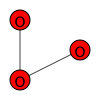

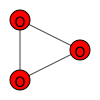

In [50]:
for g in enumerate_graphs_for_stoich(make_stoichiometry(O=3)):
    g.vs['label'] = [ELEMENTS[i] for i in g.vs['element_idx']]
    display(igraph.plot(g, layout='circle', bbox=(100, 100), vertex_size=20))
                              

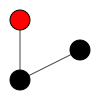

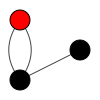

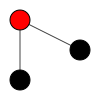

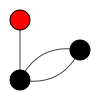

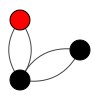

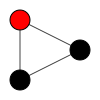

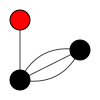

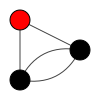

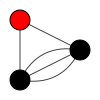

In [51]:
for g in enumerate_graphs_for_stoich(make_stoichiometry(C=2, O=1)):
    #print g.vs['element_idx']
    #g.vs['label'] = [ELEMENTS[i] for i in g.vs['element_idx']]
    #g.vs['label'] = ['-C'] * 6
    #print g.vs['element_idx']
    #print g.vs['label']
    display(igraph.plot(g, layout='circle', bbox=(100, 100), vertex_size=20, 
                        vertex_color=[ELEMENT_COLORS[i] for i in g.vs['element_idx']]))
                              

In [52]:
def enumerate_graphs(num_heavy):
    for stoich in enumerate_stoichiometries(num_heavy):
        for g in enumerate_graphs_for_stoich(stoich):
            yield g
        


In [53]:
def count_graphs(num_heavy):
    count = 0
    for g in enumerate_graphs(num_heavy):
        #display(igraph.plot(g, layout='circle', bbox=(75, 75), vertex_size=10, 
        #                    vertex_color=[ELEMENT_COLORS[i] for i in g.vs['element_idx']]))
        count += 1
    return count

In [54]:
%%time
count_graphs(3)

CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 53.8 ms


109

In [55]:
%%time
count_graphs(4)

CPU times: user 708 ms, sys: 4 ms, total: 712 ms
Wall time: 705 ms


806

In [56]:
%%time
count_graphs(5)

CPU times: user 14.6 s, sys: 84 ms, total: 14.6 s
Wall time: 14.6 s


7000

In [57]:
%%time
count_graphs(6)

CPU times: user 7min 13s, sys: 2.11 s, total: 7min 15s
Wall time: 7min 14s


71649

In [58]:
%%time
count_graphs(7)

CPU times: user 4h 42min 7s, sys: 1min 19s, total: 4h 43min 26s
Wall time: 4h 42min 46s


820064